This notebook introduces the use of pandas and the formula framework in statsmodels in the context of linear modeling.

**It is based heavily on Jonathan Taylor's [class notes that use R](http://www.stanford.edu/class/stats191/interactions.html)**

In [22]:
import matplotlib.pyplot as plt
import pandas
import numpy as np

from statsmodels.formula.api import ols
from statsmodels.graphics.api import interaction_plot, abline_plot, qqplot
from statsmodels.stats.api import anova_lm

## Example 1: IT salary data

In [15]:
url = 'http://stats191.stanford.edu/data/salary.table'
salary_table = pandas.read_table(url) # needs pandas 0.7.3
#salary_table.to_csv('salary.table', index=False)

In [16]:
print(salary_table[1:11])

        S  X  E  M
1   11608  1  3  0
2   18701  1  3  1
3   11283  1  2  0
4   11767  1  3  0
5   20872  2  2  1
6   11772  2  2  0
7   10535  2  1  0
8   12195  2  3  0
9   12313  3  2  0
10  14975  3  1  1


In [17]:
E = salary_table.E # Education
M = salary_table.M # Management
X = salary_table.X # Experience
S = salary_table.S # Salary

Let's explore the data

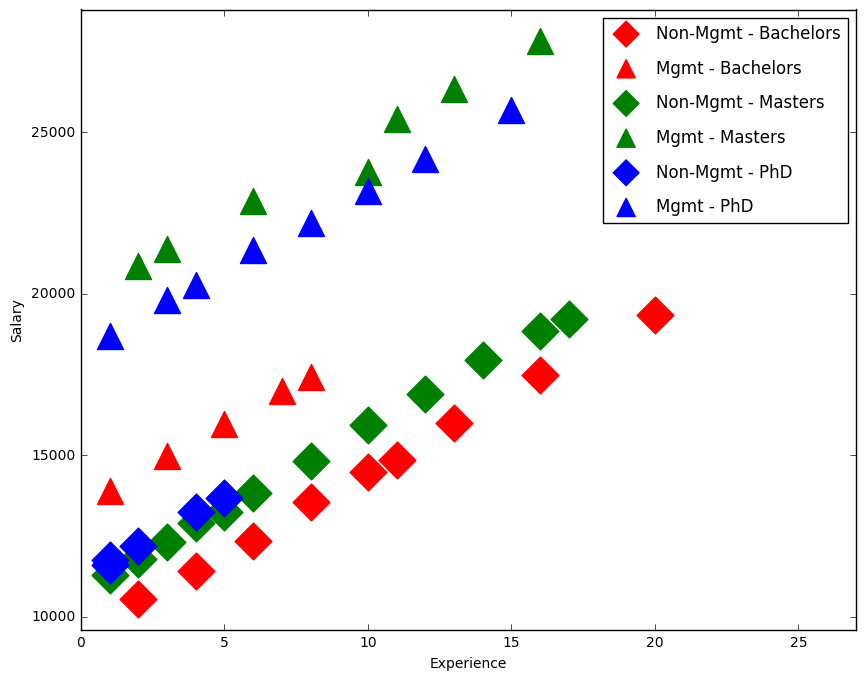

In [26]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, xlabel='Experience', ylabel='Salary',
            xlim=(0, 27), ylim=(9600, 28800))
symbols = ['D', '^']
man_label = ["Non-Mgmt", "Mgmt"]
educ_label = ["Bachelors", "Masters", "PhD"]
colors = ['r', 'g', 'blue']
factor_groups = salary_table.groupby(['E','M'])
for values, group in factor_groups:
    i,j = values
    label = "%s - %s" % (man_label[j], educ_label[i-1])
    ax.scatter(group['X'], group['S'], marker=symbols[j], color=colors[i-1],
               s=350, label=label)
ax.legend(scatterpoints=1, markerscale=.7, labelspacing=1);
fig

Fit a linear model

$$S_i = \beta_0 + \beta_1X_i + \beta_2E_{i2} + \beta_3E_{i3} + \beta_4M_i + \epsilon_i$$

where

$$ E_{i2}=\cases{1,&if $E_i=2$;\cr 0,&otherwise. \cr}$$ 
$$ E_{i3}=\cases{1,&if $E_i=3$;\cr 0,&otherwise. \cr}$$ 


In [29]:
formula = 'S ~ C(E) + C(M) + X'
# HC3 option ensures heteroscedasticity-robust std. errors
lm = ols(formula, salary_table).fit(cov_type='HC3')
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                      S   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     308.7
Date:                Sun, 23 Oct 2016   Prob (F-statistic):           5.14e-30
Time:                        19:24:47   Log-Likelihood:                -381.63
No. Observations:                  46   AIC:                             773.3
Df Residuals:                      41   BIC:                             782.4
Df Model:                           4                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   8035.5976    490.457     16.384      0.0

## Aside: Contrasts (see contrasts notebook)

Look at the design matrix created for us. Every results instance has a reference to the model.

In [30]:
lm.model.exog[:10]

array([[ 1.,  0.,  0.,  1.,  1.],
       [ 1.,  0.,  1.,  0.,  1.],
       [ 1.,  0.,  1.,  1.,  1.],
       [ 1.,  1.,  0.,  0.,  1.],
       [ 1.,  0.,  1.,  0.,  1.],
       [ 1.,  1.,  0.,  1.,  2.],
       [ 1.,  1.,  0.,  0.,  2.],
       [ 1.,  0.,  0.,  0.,  2.],
       [ 1.,  0.,  1.,  0.,  2.],
       [ 1.,  1.,  0.,  0.,  3.]])

Since we initially passed in a DataFrame, we have a transformed DataFrame available.

In [35]:
print(lm.model.data.orig_exog.head(10))

   Intercept  C(E)[T.2]  C(E)[T.3]  C(M)[T.1]    X
0        1.0        0.0        0.0        1.0  1.0
1        1.0        0.0        1.0        0.0  1.0
2        1.0        0.0        1.0        1.0  1.0
3        1.0        1.0        0.0        0.0  1.0
4        1.0        0.0        1.0        0.0  1.0
5        1.0        1.0        0.0        1.0  2.0
6        1.0        1.0        0.0        0.0  2.0
7        1.0        0.0        0.0        0.0  2.0
8        1.0        0.0        1.0        0.0  2.0
9        1.0        1.0        0.0        0.0  3.0


There is a reference to the original untouched data in

In [33]:
print(lm.model.data.frame.head(10))

       S  X  E  M
0  13876  1  1  1
1  11608  1  3  0
2  18701  1  3  1
3  11283  1  2  0
4  11767  1  3  0
5  20872  2  2  1
6  11772  2  2  0
7  10535  2  1  0
8  12195  2  3  0
9  12313  3  2  0


If you use the formula interface, statsmodels remembers this transformation. Say you want to know the predicted salary for someone with 12 years experience and a Master's degree who is in a management position

In [36]:
lm.predict({'X' : [12], 'M' : [1], 'E' : [2]})

array([ 24617.37207242])

So far we've assumed that the effect of experience is the same for each level of education and professional role.
Perhaps this assumption isn't merited. We can formally test this using some interactions.

We can start by seeing if our model assumptions are met. Let's look at a residuals plot.

And some formal tests

Plot the residuals within the groups separately.

In [37]:
resid = lm.resid

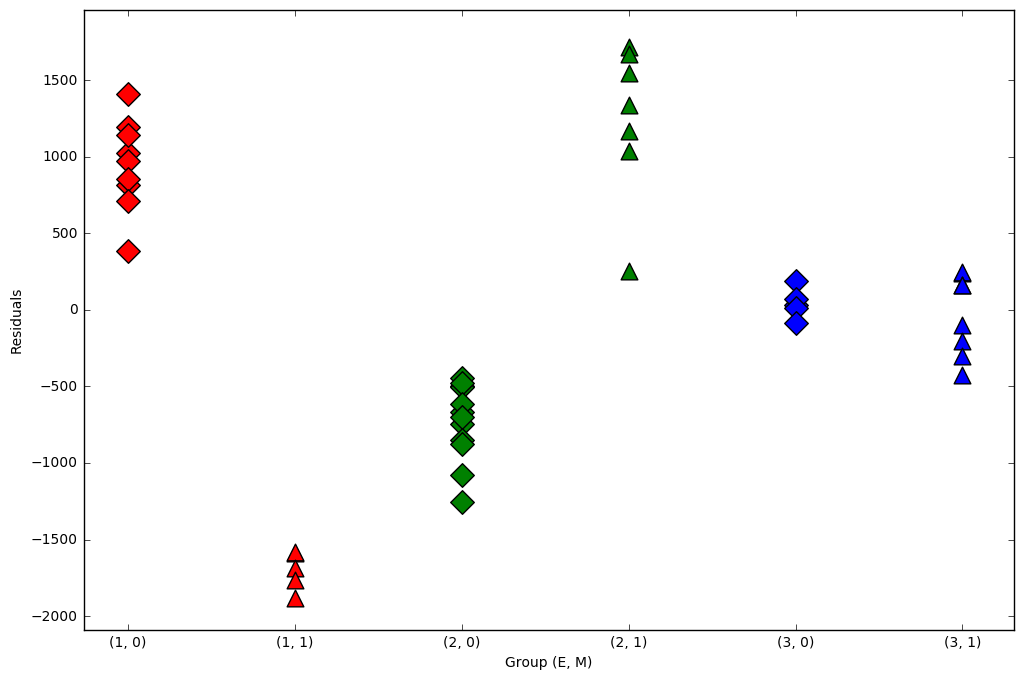

In [39]:
fig = plt.figure(figsize=(12,8))
xticks = []
ax = fig.add_subplot(111, xlabel='Group (E, M)', ylabel='Residuals')
for values, group in factor_groups:
    i,j = values
    xticks.append(str((i, j)))
    group_num = i*2 + j - 1 # for plotting purposes
    x = [group_num] * len(group)
    ax.scatter(x, resid[group.index], marker=symbols[j], color=colors[i-1],
            s=144, edgecolors='black')
ax.set_xticks([1,2,3,4,5,6])
ax.set_xticklabels(xticks)
ax.axis('tight');
fig

Add an interaction between salary and experience, allowing different intercepts for level of experience.

$$S_i = \beta_0+\beta_1X_i+\beta_2E_{i2}+\beta_3E_{i3}+\beta_4M_i+\beta_5E_{i2}X_i+\beta_6E_{i3}X_i+\epsilon_i$$

In [ ]:
interX_lm = ols('S ~ C(E)*X + C(M)', salary_table).fit()
print interX_lm.summary()

Test that $\beta_5 = \beta_6 = 0$. We can use anova_lm or we can use an F-test.

In [ ]:
print anova_lm(lm, interX_lm)

In [ ]:
print interX_lm.f_test('C(E)[T.2]:X = C(E)[T.3]:X = 0')

In [ ]:
print interX_lm.f_test([[0,0,0,0,0,1,-1],[0,0,0,0,0,0,1]])

The contrasts are created here under the hood by patsy.

Recall that F-tests are of the form $R\beta = q$

In [ ]:
LC = interX_lm.model.data.orig_exog.design_info.linear_constraint('C(E)[T.2]:X = C(E)[T.3]:X = 0')
print LC.coefs
print LC.constants

Interact education with management

In [ ]:
interM_lm = ols('S ~ X + C(E)*C(M)', salary_table).fit()
print interM_lm.summary()

In [ ]:
print anova_lm(lm, interM_lm)

In [ ]:
infl = interM_lm.get_influence()
resid = infl.resid_studentized_internal

In [ ]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, xlabel='X', ylabel='standardized resids')

for values, group in factor_groups:
    i,j = values
    idx = group.index
    ax.scatter(X[idx], resid[idx], marker=symbols[j], color=colors[i-1],
            s=144, edgecolors='black')
ax.axis('tight');

There looks to be an outlier.

In [ ]:
outl = interM_lm.outlier_test('fdr_bh')
outl.sort('unadj_p', inplace=True)
print outl

In [ ]:
idx = salary_table.index.drop(32)

In [ ]:
print idx

In [ ]:
lm32 = ols('S ~ C(E) + X + C(M)', data=salary_table, subset=idx).fit()
print lm32.summary()

In [ ]:
interX_lm32 = ols('S ~ C(E) * X + C(M)', data=salary_table, subset=idx).fit()
print interX_lm32.summary()

In [ ]:
table3 = anova_lm(lm32, interX_lm32)
print table3

In [ ]:
interM_lm32 = ols('S ~ X + C(E) * C(M)', data=salary_table, subset=idx).fit()
print anova_lm(lm32, interM_lm32)

Re-plotting the residuals

In [ ]:
resid = interM_lm32.get_influence().summary_frame()['standard_resid']
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, xlabel='X[~[32]]', ylabel='standardized resids')

for values, group in factor_groups:
    i,j = values
    idx = group.index
    ax.scatter(X[idx], resid[idx], marker=symbols[j], color=colors[i-1],
            s=144, edgecolors='black')
ax.axis('tight');

A final plot of the fitted values

In [ ]:
lm_final = ols('S ~ X + C(E)*C(M)', data=salary_table.drop([32])).fit()
mf = lm_final.model.data.orig_exog
lstyle = ['-','--']

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, xlabel='Experience', ylabel='Salary')

for values, group in factor_groups:
    i,j = values
    idx = group.index
    ax.scatter(X[idx], S[idx], marker=symbols[j], color=colors[i-1],
            s=144, edgecolors='black')
    # drop NA because there is no idx 32 in the final model
    ax.plot(mf.X[idx].dropna(), lm_final.fittedvalues[idx].dropna(),
            ls=lstyle[j], color=colors[i-1])
ax.axis('tight');

In [ ]:
U = S - X * interX_lm32.params['X']
U.name = 'Salary|X'

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax = interaction_plot(E, M, U, colors=['red','blue'], markers=['^','D'],
        markersize=10, ax=ax)

### Minority Employment Data - ABLine plotting

In [ ]:
try:
    minority_table = pandas.read_table('minority.table')
except: # don't have data already
    url = 'http://stats191.stanford.edu/data/minority.table'
    minority_table = pandas.read_table(url)
    minority_table.to_csv('minority.table', sep="\t", index=False)

In [ ]:
factor_group = minority_table.groupby(['ETHN'])

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, xlabel='TEST', ylabel='JPERF')
colors = ['purple', 'green']
markers = ['o', 'v']
for factor, group in factor_group:
    ax.scatter(group['TEST'], group['JPERF'], color=colors[factor],
                marker=markers[factor], s=12**2)
ax.legend(['ETHN == 1', 'ETHN == 0'], scatterpoints=1)

In [ ]:
min_lm = ols('JPERF ~ TEST', data=minority_table).fit()
print min_lm.summary()

In [ ]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, xlabel='TEST', ylabel='JPERF')
for factor, group in factor_group:
    ax.scatter(group['TEST'], group['JPERF'], color=colors[factor],
                marker=markers[factor], s=12**2)
ax.legend(['ETHN == 1', 'ETHN == 0'], scatterpoints=1, loc='upper left')
fig = abline_plot(model_results = min_lm, ax=ax)

In [ ]:
min_lm2 = ols('JPERF ~ TEST + TEST:ETHN', data=minority_table).fit()
print min_lm2.summary()

In [ ]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, xlabel='TEST', ylabel='JPERF')
for factor, group in factor_group:
    ax.scatter(group['TEST'], group['JPERF'], color=colors[factor],
                marker=markers[factor], s=12**2)

fig = abline_plot(intercept = min_lm2.params['Intercept'],
                 slope = min_lm2.params['TEST'], ax=ax, color='purple')
ax = fig.axes[0]
fig = abline_plot(intercept = min_lm2.params['Intercept'],
        slope = min_lm2.params['TEST'] + min_lm2.params['TEST:ETHN'],
        ax=ax, color='green')
ax.legend(['ETHN == 1', 'ETHN == 0'], scatterpoints=1, loc='upper left');

In [ ]:
min_lm3 = ols('JPERF ~ TEST + ETHN', data=minority_table).fit()
print min_lm3.summary()

In [ ]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, xlabel='TEST', ylabel='JPERF')
for factor, group in factor_group:
    ax.scatter(group['TEST'], group['JPERF'], color=colors[factor],
                marker=markers[factor], s=12**2)

fig = abline_plot(intercept = min_lm3.params['Intercept'],
                 slope = min_lm3.params['TEST'], ax=ax, color='purple')

ax = fig.axes[0]
fig = abline_plot(intercept = min_lm3.params['Intercept'] + min_lm3.params['ETHN'],
        slope = min_lm3.params['TEST'], ax=ax, color='green')
ax.legend(['ETHN == 1', 'ETHN == 0'], scatterpoints=1, loc='upper left');

In [ ]:
min_lm4 = ols('JPERF ~ TEST * ETHN', data=minority_table).fit()
print min_lm4.summary()

In [ ]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, ylabel='JPERF', xlabel='TEST')
for factor, group in factor_group:
    ax.scatter(group['TEST'], group['JPERF'], color=colors[factor],
                marker=markers[factor], s=12**2)

fig = abline_plot(intercept = min_lm4.params['Intercept'],
                 slope = min_lm4.params['TEST'], ax=ax, color='purple')
ax = fig.axes[0]
fig = abline_plot(intercept = min_lm4.params['Intercept'] + min_lm4.params['ETHN'],
        slope = min_lm4.params['TEST'] + min_lm4.params['TEST:ETHN'],
        ax=ax, color='green')
ax.legend(['ETHN == 1', 'ETHN == 0'], scatterpoints=1, loc='upper left');

Is there any effect of ETHN on slope or intercept?
<br />
Y ~ TEST vs. Y ~ TEST + ETHN + ETHN:TEST

In [ ]:
table5 = anova_lm(min_lm, min_lm4)
print table5

Is there any effect of ETHN on intercept?
<br />
Y ~ TEST vs. Y ~ TEST + ETHN

In [ ]:
table6 = anova_lm(min_lm, min_lm3)
print table6

Is there any effect of ETHN on slope?
<br />
Y ~ TEST vs. Y ~ TEST + ETHN:TEST

In [ ]:
table7 = anova_lm(min_lm, min_lm2)
print table7

Is it just the slope or both?
<br />
Y ~ TEST + ETHN:TEST vs Y ~ TEST + ETHN + ETHN:TEST

In [ ]:
table8 = anova_lm(min_lm2, min_lm4)
print table8

### Two Way ANOVA - Kidney failure data

In [ ]:
try:
    kidney_table = pandas.read_table('kidney.table')
except:
    url = 'http://stats191.stanford.edu/data/kidney.table'
    kidney_table = pandas.read_table(url, delimiter=" *")
    kidney_table.to_csv("kidney.table", sep="\t", index=False)

In [ ]:
# Explore the dataset, it's a balanced design
print kidney_table.groupby(['Weight', 'Duration']).size()

In [ ]:
kt = kidney_table
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
fig = interaction_plot(kt['Weight'], kt['Duration'], np.log(kt['Days']+1),
        colors=['red', 'blue'], markers=['D','^'], ms=10, ax=ax)

$$Y_{ijk} = \mu + \alpha_i + \beta_j + \left(\alpha\beta\right)_{ij}+\epsilon_{ijk}$$

with 

$$\epsilon_{ijk}\sim N\left(0,\sigma^2\right)$$

In [ ]:
help(anova_lm)

Things available in the calling namespace are available in the formula evaluation namespace

In [ ]:
kidney_lm = ols('np.log(Days+1) ~ C(Duration) * C(Weight)', data=kt).fit()

ANOVA Type-I Sum of Squares
<br /><br />
SS(A) for factor A. <br />
SS(B|A) for factor B. <br />
SS(AB|B, A) for interaction AB. <br />

In [ ]:
print anova_lm(kidney_lm)

ANOVA Type-II Sum of Squares
<br /><br />
SS(A|B) for factor A. <br />
SS(B|A) for factor B. <br />

In [ ]:
print anova_lm(kidney_lm, typ=2)

In [ ]:
print anova_lm(ols('np.log(Days+1) ~ C(Duration, Sum) * C(Weight, Poly)', 
                   data=kt).fit(), typ=3)

#### Excercise: Find the 'best' model for the kidney failure dataset